<a href="https://colab.research.google.com/github/emilia-uncc/IntroML/blob/main/Assignment6/Homework6_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

import datetime

#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data_path = '/content/drive/My Drive/DataSets/'
cifar10 = datasets.CIFAR10(data_path,train=True,download=True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform = transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(cifar10)

50000

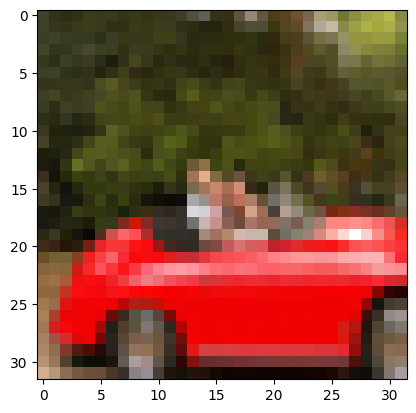

In [4]:
img_t, _ = cifar10[99]
img_t.shape
plt.imshow(img_t.permute(1,2,0))

In [5]:
imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [6]:
imgs.view(3,-1).mean(dim=1)
imgs.view(3,-1).std(dim=1)


tensor([0.2470, 0.2435, 0.2616])

In [7]:
transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [13]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True,download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False,download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))

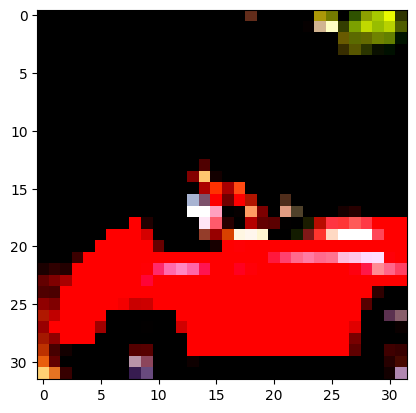

In [9]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()

In [14]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 824),
                      nn.Tanh(),
                      nn.Linear(824, 204),
                      nn.Tanh(),
                      nn.Linear(204, 10),
                      nn.LogSoftmax(dim=1))



In [15]:
#count trainable parameter
numel_list = [p.numel()
              for p in model.parameters()
              if p.requires_grad == True]
sum(numel_list)

2166438

In [16]:
loss = nn.NLLLoss()
img, label = transformed_cifar10[99]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(2.3363, grad_fn=<NllLossBackward0>)

In [13]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size = 64, shuffle=True)

loss_fn = nn.NLLLoss()
n_epochs = 300
losses = []
start = datetime.datetime.now()
for epoch in range(n_epochs):
  for imgs, labels in train_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
  losses.append(loss.item())

end = datetime.datetime.now()

Epoch: 0, Loss: 1.528864
Epoch: 1, Loss: 1.604502
Epoch: 2, Loss: 1.800628
Epoch: 3, Loss: 1.760673
Epoch: 4, Loss: 1.671221
Epoch: 5, Loss: 1.504973
Epoch: 6, Loss: 1.194758
Epoch: 7, Loss: 2.258765
Epoch: 8, Loss: 1.717912
Epoch: 9, Loss: 1.698834
Epoch: 10, Loss: 1.438654
Epoch: 11, Loss: 0.905498
Epoch: 12, Loss: 0.919835
Epoch: 13, Loss: 0.793843
Epoch: 14, Loss: 1.250841
Epoch: 15, Loss: 1.284530
Epoch: 16, Loss: 1.009971
Epoch: 17, Loss: 0.974535
Epoch: 18, Loss: 0.726999
Epoch: 19, Loss: 0.887596
Epoch: 20, Loss: 0.947173
Epoch: 21, Loss: 0.640259
Epoch: 22, Loss: 1.295103
Epoch: 23, Loss: 1.006855
Epoch: 24, Loss: 0.707785
Epoch: 25, Loss: 0.643270
Epoch: 26, Loss: 0.615790
Epoch: 27, Loss: 0.845667
Epoch: 28, Loss: 0.170917
Epoch: 29, Loss: 0.263944
Epoch: 30, Loss: 0.583269
Epoch: 31, Loss: 0.495518
Epoch: 32, Loss: 0.761224
Epoch: 33, Loss: 0.395232
Epoch: 34, Loss: 0.765792
Epoch: 35, Loss: 0.169214
Epoch: 36, Loss: 0.690230
Epoch: 37, Loss: 0.189916
Epoch: 38, Loss: 0.419

In [14]:
time = end-start
print("Training time: ", str(time))

Training time:  2:09:03.497036


In [17]:
#!!!
#save model
#torch.save(model.state_dict(), data_path+'p2b_0.01.pt')

#Load model
model.load_state_dict(torch.load(data_path+'p2b_0.01.pt'))

<All keys matched successfully>

Text(0.5, 47.7222222222222, 'Predicted label')

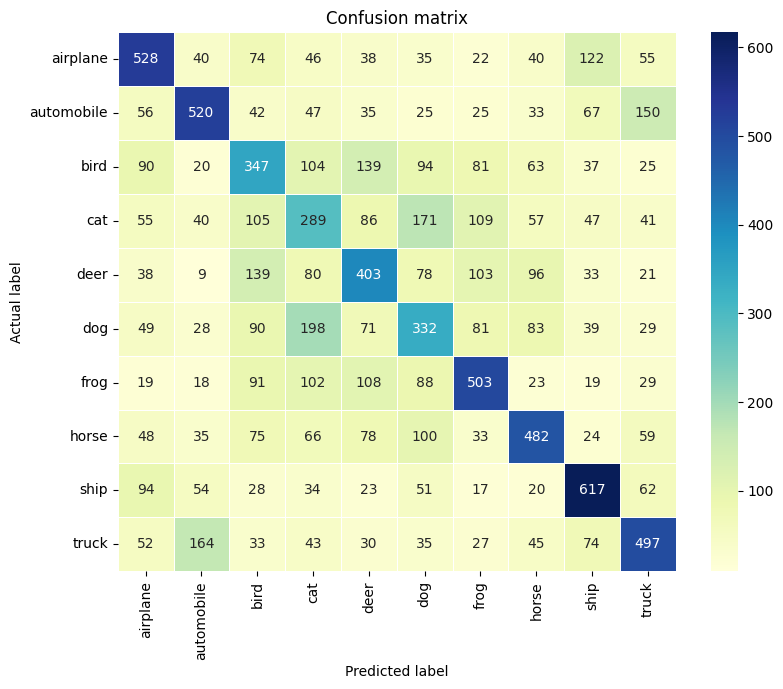

In [19]:
#Confusion matrix
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64, shuffle=False)
loss_fn = nn.NLLLoss()
nb_classes = 10
cnf_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for imgs, labels in val_loader:

        outputs = model(imgs.view(imgs.shape[0], -1))
        _, preds = torch.max(outputs, 1)

        for t, p in zip(labels.view(-1), preds.view(-1)):
                cnf_matrix[t.long(), p.long()] += 1


# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g',linewidths=0.5,  xticklabels=class_names, yticklabels=class_names, ax=ax)

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [20]:
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
  shuffle=False)
correct_val = 0
total_val = 0
loss_fn = nn.NLLLoss()
val_losses = []
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        val_losses.append(loss.item())
        _, predicted = torch.max(outputs, dim=1)
        total_val += labels.shape[0]
        correct_val += int((predicted == labels).sum())
print("Accuracy validation: %f", correct_val / total_val)


Accuracy validation: %f 0.4518


In [21]:
#Training set accuracy
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy training: %f" % (correct / total))

Accuracy training: 1.000000


In [22]:
cm = pd.DataFrame(cnf_matrix)

recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
f1_score = (2*recall*precision) / (recall+precision)

d = {'class':class_names, 'precision':precision, 'recall':recall, 'f1-score':f1_score}
performance = pd.DataFrame(data = d)

In [23]:
precision_mean = np.sum(performance['precision']) / 10
recall_mean = np.sum(performance['recall']) / 10
f1_mean = np.sum(performance['f1-score']) / 10

print("Accuracy:   %.4f" % (correct_val / total_val))
print("Precsision: %.4f" % precision_mean)
print("Recall:     %.4f" % recall_mean)
print("F1-score:   %.4f" % f1_mean)

print('\n')
print("Training Accuracy: %.4f" % (correct / total))

Accuracy:   0.4518
Precsision: 0.4526
Recall:     0.4518
F1-score:   0.4520


Training Accuracy: 1.0000


In [24]:
# 4. Plot the training and validation loss after each iteration
plt.plot(losses, label="training loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

NameError: ignored